# Assembling data for the Hyades

In [276]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from tqdm import tqdm

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [277]:
def convert_hours_to_degrees(df, ra_name, dec_name):
    RA, DE = [], [] #[np.zeros(len(douglas)) for i in range(2)]
    for i in range(len(df)):     
        coords = "{0} {1}".format(df[ra_name].values[i], df[dec_name].values[i])
        c = SkyCoord(coords, unit=(u.hourangle, u.deg))
        RA.append(c.ra.degree)
        DE.append(c.dec.degree)
    df["ra"] = RA
    df["dec"] = DE
    return df

# Douglas rotation periods

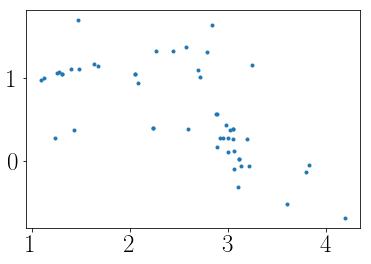

In [278]:
douglas = pd.read_csv("../data/hyades.csv")
m = 0 < douglas.prot.values
plt.plot(douglas.bp[m] - douglas.rp[m], np.log10(douglas.prot[m]), ".")

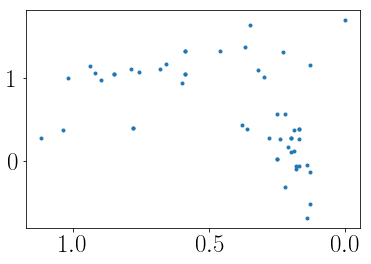

In [279]:
mass = []
for i, ma in enumerate(douglas.Mass.values):
    try:
        mass.append(float(ma))
    except:
        mass.append(0.)
douglas["mass"] = np.array(mass)
plt.plot(douglas.mass.values[m], np.log10(douglas.prot.values[m]), ".")
plt.gca().invert_xaxis()

Combine Douglas, Delorme and Radick (still need to add Hartman, Prosser and ASAS).

# Delorme

In [333]:
de = pd.read_csv("../data/hyades_delorme.csv", skiprows=70)
delorme = pd.DataFrame(dict({
                             "prot": de.Per,
                             "J-Ks": de["J-Ks"],
                             "Ks": de.Ksmag,
                             "vmag": de.Vmag,
                             "B-V": de["B-Vl"],
                             "ra": de._RA,
                             "dec": de._DE
                              }))

In [334]:
radick87= pd.read_csv("../data/hyades_radick_1987.csv")
radick95= pd.read_csv("../data/hyades_radick_1995.csv")

# Hartman

In [ ]:
ha = pd.read_csv("../data/hartman.csv", skiprows=76)
ha = convert_hours_to_degrees(ha, "RAJ2000", "DEJ2000")
hartman = pd.DataFrame(dict({"ra": ha.ra, "dec": ha.dec,
                             "jmag": ha.Jmag,
                             "kmag": ha.Kmag,
                             "hmag": ha.Hmag,
                             "vmag": ha.Vmag,
                             "prot": ha.Pe
}))

In [281]:
from astropy.coordinates import FK5

RAJ2000, DEJ2000 = [], []
for i in range(len(radick87)):
    coord = SkyCoord(radick87.RAJ1950.values[i], radick87.decJ1950.values[i], 
                     unit=(u.hourangle, u.deg), equinox="J1950")
    rd = coord.transform_to(FK5(equinox='J2000'))
    RAJ2000.append(rd.ra.degree)
    DEJ2000.append(rd.dec.degree)

radick87["RAJ2000"] = np.array(RAJ2000)
radick87["DEJ2000"] = np.array(DEJ2000)

Load the gaia crossmatch for the clusters.

In [282]:
gaia = pd.read_csv("../data/gaia_cluster_crossmatch.csv", skiprows=49)
m = gaia.Cluster.values == "Hyades  "
hg = gaia.iloc[m]
hg.head()
hg["source_id"] = hg.Source

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


And Megan Bedell's K2 - Gaia crossmatch.

In [283]:
bedell = pd.read_csv("K2_c4_gaia.csv")
# for i in bedell.keys():
#     print(i)

Match the two.

In [284]:
# g["source_id"] = hg.Source
# hg = pd.merge(g, bedell, on="source_id")
# print(np.shape(hg))

# distance, closest_ra, closest_dec, ind1, ind2 = find_min_dist(g.RA_ICRS, g.DE_ICRS, bedell.ra, bedell.dec)
# print(sum(ind1), sum(ind2), "matches")

(-1, 36)

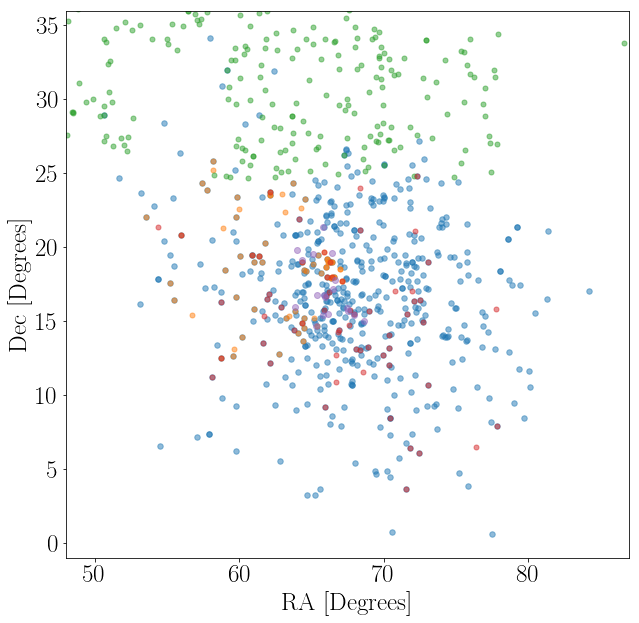

In [285]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(douglas.ra, douglas.dec, s=25, zorder=1, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=2, alpha=.5)
plt.scatter(delorme._RA, delorme._DE, s=25, zorder=3, alpha=.5)
plt.scatter(radick87.RAJ2000, radick87.DEJ2000, zorder=4, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find closest matches between Gaia and other catalogues.

In [308]:
def find_min_dist(ra1, dec1, ra2, dec2, dist_arcsecs=5.):
    """
    ind1 is a list of indices the same length as ra1 and dec1 that identifies matching stars in ra1 and dec1.
    ind2 is a list of indices the same length as ra2 and dec2 that identifies matching stars in ra2 and dec2.
    """
    closest_ra, closest_dec, distance, ind1, ind2 = [], [], [], [], []
    for i in tqdm(range(len(ra1))):
        e2 = np.sqrt((ra2.values - ra1.values[i])**2 + (dec2.values - dec1.values[i])**2)
        min_distance = min(e2)
        if min_distance < dist_arcsecs/3600.:
            m = e2 == min_distance
            if sum(m) > 1:
                m = np.arange(len(ra2))[m[0]]
            closest_ra.append(ra1.values[i])
            closest_dec.append(dec1.values[i])
            distance.append(min_distance)
            ind1.append(i)
            ind2.append(np.arange(len(ra2))[m])
            
    m1, m2 = np.zeros(len(ra1), dtype="bool"), np.zeros(len(ra2), dtype="bool")
    for i in ind1:
        m1[i] = True
    for i in ind2:
        m2[i] = True
    return np.array(distance), np.array(closest_ra), np.array(closest_dec), m1, m2

# Gaia and Hartman

Hartman has J, H and K colors, V-band magnitudes, and the rotation period column is "Pe".

In [309]:
hartman["prot"] = hartman.Pe
hartman.head()

,HAT,n_HAT,pmRA,pmDE,Jmag,Hmag,Kmag,Vmag,r_Vmag,Pe,...,dR.t2,Qt,N,2M,Simbad,RAJ2000,DEJ2000,ra,dec,prot
0,086-0001701,,35.13,-36.72,9.519,8.763,8.658,12.136,1,,...,0.005,0,2,2M,Simbad,00 13 38.42,+52 45 05.0,3.410083,52.751389,
1,086-0004017,,35.30,35.51,9.565,8.804,8.643,12.235,1,40.868328,...,,2,2,2M,Simbad,23 54 23.85,+54 41 26.9,358.599375,54.690806,40.868328
2,086-0005153,,76.13,-7.77,9.906,9.239,9.060,12.822,1,16.368924,...,,2,4,2M,Simbad,23 51 18.20,+54 35 16.2,357.825833,54.587833,16.368924
3,086-0005542,,146.68,-27.87,9.980,9.349,9.137,12.767,1,20.363047,...,0.009,0,3,2M,Simbad,00 16 56.01,+50 37 49.0,4.233375,50.630278,20.363047
4,086-0005602,x,-83.81,51.47,10.008,9.409,9.186,12.870,1,,...,0.009,1,0,2M,Simbad,00 16 01.61,+48 55 56.9,4.006708,48.932472,


(-1, 36)

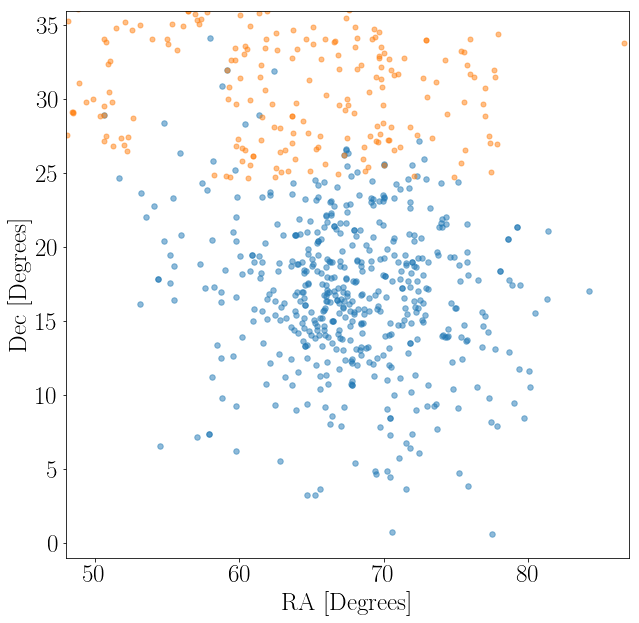

In [310]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(hartman.ra, hartman.dec, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find the closest stars

In [311]:
distance, closest_ra, closest_dec, ind1, ind2 = find_min_dist(hg.RA_ICRS, hg.DE_ICRS, hartman.ra, hartman.dec)
print(sum(ind1), sum(ind2), "matches")

100%|██████████| 515/515 [00:00<00:00, 2944.61it/s]

4 4 matches


Text(0,0.5,'dec')

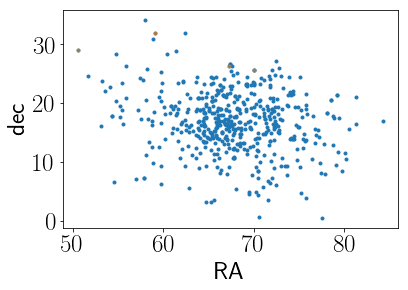

In [312]:
plt.plot(hg.RA_ICRS, hg.DE_ICRS, ".")
plt.plot(hg.RA_ICRS.values[ind1], hg.DE_ICRS.values[ind1], ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("dec")

Now add the Hartman catalogue on to the Douglas catalogue.

In [318]:
hart_gaia = hg.iloc[ind1].join(hartman.iloc[ind2])
print(np.shape(hart_gaia), np.shape(hg), np.shape(hartman))
hart_gaia["ra"] = hart_gaia.RA_ICRS
hart_gaia["dec"] = hart_gaia.DE_ICRS

df1 = pd.concat((douglas, hart_gaia))
print(np.shape(douglas), np.shape(hart_gaia), np.shape(df1))

(4, 35) (515, 10) (2033, 25)
(73, 38) (4, 35) (77, 67)


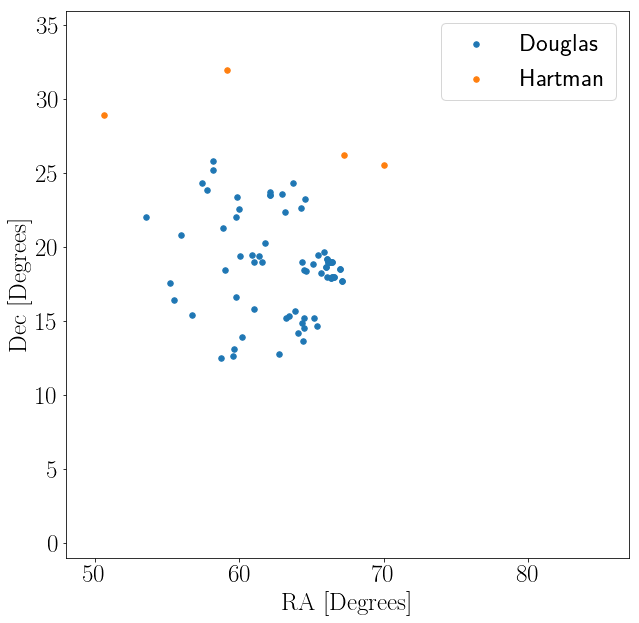

In [292]:
plt.figure(figsize=(width*f, height*f))
plt.scatter(df1.iloc[:73].ra, df1.iloc[:73].dec, s=30, zorder=0, label="Douglas")
plt.scatter(df1.iloc[73:].ra, df1.iloc[73:].dec, s=30, zorder=1, label="Hartman")
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)
plt.legend()

# Gaia and Delorme

Delorme has J-Ks colour, V-band magnitudes and the Period column is called "Per".

In [319]:
delorme["prot"] = delorme.Per
delorme.head()

,SWASP,X,Per,J-Ks,Ksmag,Vmag,Dist,pmRA,e_pmRA,pmDE,...,plx,Mmb,SpType,Vmagl,B-Vl,Ref,SimbadName,_RA,_DE,prot
0,J033734.97+212035.4,Yes,10.57,0.524,7.12,9.30,12.4,141.5,1.7,-27.3,...,25.18,1.0,G5,9.36,0.92,2,Melotte 25 5,54.39571,21.34317,10.57
1,J034347.07+205136.4,No,12.30,0.871,9.61,,10.9,140.0,1.0,-32.0,...,,1.0,,14.54,0.90,4,,55.94612,20.86011,12.30
2,J035234.31+111538.6,No,13.29,0.858,9.01,,10.2,166.0,15.0,-10.0,...,,1.0,M,13.73,1.54,2,,58.14296,11.26072,13.29
3,J035453.20+161856.3,Yes,6.04,0.905,9.06,,7.7,130.0,2.0,-18.0,...,,1.0,M,14.25,1.58,2,,58.72167,16.31564,6.04
4,J035501.43+122908.1,,11.66,0.607,7.57,10.00,8.9,127.5,2.1,-9.6,...,25.62,1.0,M0,10.12,1.07,1,Cl* Melotte 25 S 155,58.75596,12.48558,11.66


(-1, 36)

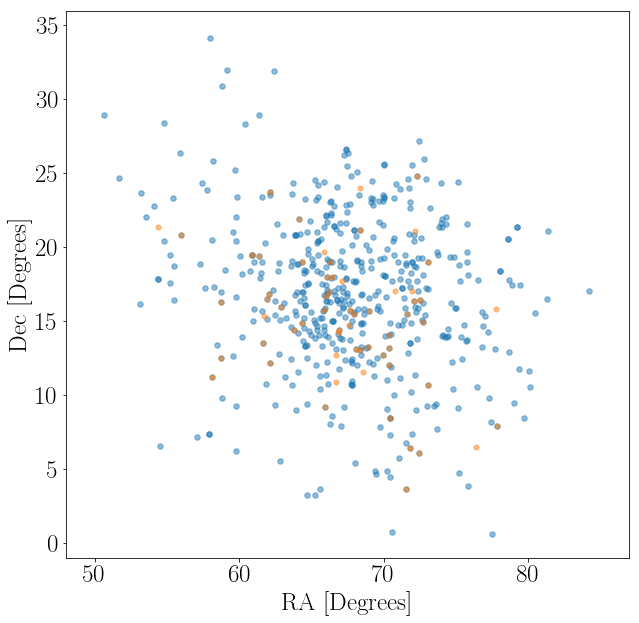

In [320]:
f = .3
width, height = (max(hg.RA_ICRS) - min(hg.RA_ICRS)), (max(hg.DE_ICRS) - min(hg.DE_ICRS))
plt.figure(figsize=(width*f, height*f))
plt.scatter(hg.RA_ICRS, hg.DE_ICRS, s=30, zorder=0, alpha=.5)
plt.scatter(delorme._RA, delorme._DE, s=25, zorder=1, alpha=.5)
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)

Find the closest stars.

In [321]:
distance, closest_ra, closest_dec, ind1, ind2 = find_min_dist(hg.RA_ICRS, hg.DE_ICRS, delorme._RA, delorme._DE)
print(sum(ind1), sum(ind2), "matches")

100%|██████████| 515/515 [00:00<00:00, 21426.26it/s]

47 45 matches


Text(0,0.5,'dec')

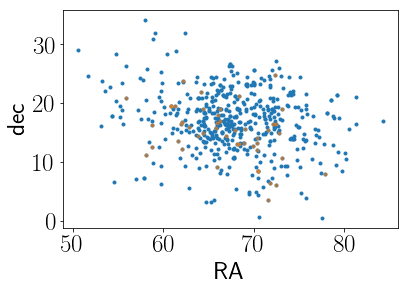

In [322]:
plt.plot(hg.RA_ICRS, hg.DE_ICRS, ".")
plt.plot(hg.RA_ICRS.values[ind1], hg.DE_ICRS.values[ind1], ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("dec")

Add Delorme to the catalogue.

In [324]:
delorme_gaia = hg.iloc[ind1].join(delorme.iloc[ind2], lsuffix="_gaia", rsuffix="delorme")
delorme_gaia["ra"] = delorme_gaia["_RA.icrs"]
delorme_gaia["dec"] = delorme_gaia["_DE.icrs"]

df2 = pd.concat((df1, delorme_gaia))
print(np.shape(df1), np.shape(delorme_gaia), np.shape(df2))

print(df2.prot)

(77, 67) (47, 33) (124, 85)
0       1.8088
1            0
2            0
3      12.3168
4       0.8584
5            0
6      12.5745
7      14.6609
8      14.3802
9            0
10      0.7257
11     23.1244
12      0.8686
13           0
14     20.7309
15      1.2774
16      1.3183
17           0
18      1.8626
19      2.6612
20     11.6032
21      0.2967
22      0.8037
23     13.8499
24      0.4812
25           0
26      9.3908
27      21.021
28      21.021
29      0.8968
        ...   
198        NaN
217        NaN
218        NaN
222        NaN
223        NaN
226        NaN
234        NaN
253        NaN
266        NaN
285        NaN
310        NaN
311        NaN
315        NaN
316        NaN
334        NaN
336        NaN
338        NaN
354        NaN
379        NaN
385        NaN
387        NaN
398        NaN
401        NaN
410        NaN
451        NaN
453        NaN
492        NaN
494        NaN
500        NaN
512        NaN
Name: prot, Length: 124, dtype: object


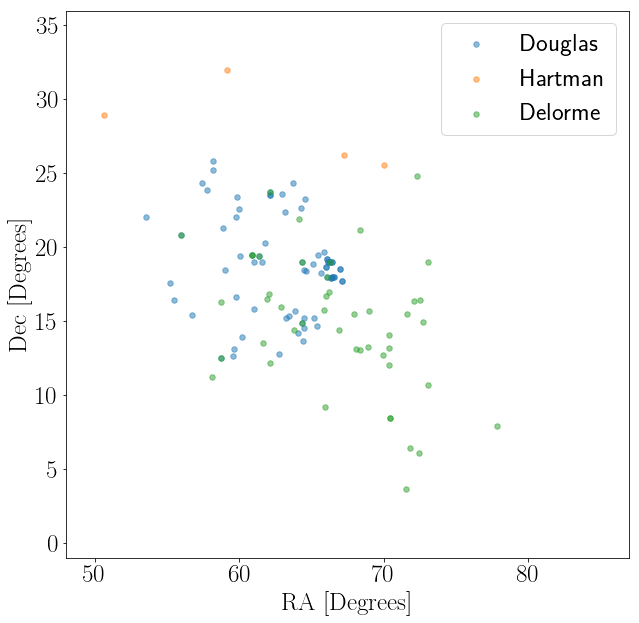

In [298]:
plt.figure(figsize=(width*f, height*f))
plt.scatter(df2.iloc[:73].ra, df2.iloc[:73].dec, s=30, zorder=0, alpha=.5, label="Douglas")
plt.scatter(df2.iloc[73:77].ra, df2.iloc[73:77].dec, s=30, zorder=1, alpha=.5, label="Hartman")
plt.scatter(df2.iloc[77:124].ra, df2.iloc[77:124].dec, s=30, zorder=2, alpha=.5, label="Delorme")
plt.xlabel("$\mathrm{RA~[Degrees]}$")
plt.ylabel("$\mathrm{Dec~[Degrees]}$")
plt.xlim(48, 87)
plt.ylim(-1, 36)
plt.legend()

In [299]:
df2.head()

,2M,2MASS,Amp,Ap,B-Vl,Bin,Bl,Cluster,DEJ2000,DE_ICRS,...,plxdelorme,pmDE,pmRA,prot,r_Vmag,ra,ra_err,rp,source_id,use
0,NaN,03341053+2204213,0.008264,4.0,NaN,2.0,N,NaN,+22 04 21.2,NaN,...,NaN,NaN,NaN,1.8088,NaN,53.544861,0.084542,13.300308,64552022725337856,corr
1,NaN,03404581+1734477,0.020289,3.0,NaN,0.0,N,NaN,+17 34 47.7,NaN,...,NaN,NaN,NaN,0,NaN,55.191643,0.114236,14.877822,44388010264995200,corr
2,NaN,03420441+1625183,0.158637,2.0,NaN,0.0,Y,NaN,+16 25 18.3,NaN,...,NaN,NaN,NaN,0,NaN,55.519163,0.088386,13.567423,44052178182130816,corr
3,NaN,03434706+2051363,0.014581,2.5,NaN,0.0,N,NaN,+20 51 36.4,NaN,...,NaN,NaN,NaN,12.3168,NaN,55.946823,0.056599,12.140936,63395989328447232,corr
4,NaN,03465952+1524170,0.005815,4.0,NaN,2.0,N,NaN,+15 24 16.8,NaN,...,NaN,NaN,NaN,0.8584,NaN,56.749149,0.143451,12.665202,42947680095257344,corr


In [300]:
# for i in df2.keys():
#     print(i)

55 124


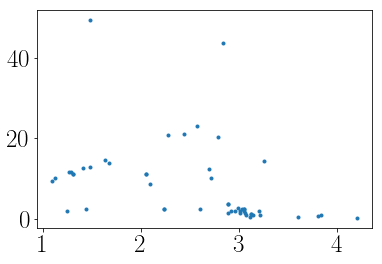

In [301]:
m = df2.prot.values > 0.
plt.plot(df2.bp.values[m] - df2.rp.values[m], df2.prot.values[m], ".")
print(len(df2.prot.values[m]), len(df2))

In [302]:
# print(df2.source_id.values)
source_ids_hyades = pd.DataFrame(dict({"source_id": df2.source_id}))
source_ids_hyades.to_csv("../data/source_ids_hyades.csv")

After performing the following query with the above data file uploaded:

SELECT *

FROM user_table_name

JOIN gaiadr2.gaia_source AS gaia USING (source_id)

In [303]:
gaia_h = pd.read_csv("../data/hyades-result.csv")
gaia_h.head()

,table2_oid,col1,solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,source_id
0,1,0,1635721458409799680,Gaia DR2 64552022725337856,805628475,2015.5,53.544861,0.084542,22.072399,0.062352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,64552022725337856
1,2,1,1635721458409799680,Gaia DR2 44388010264995200,350324408,2015.5,55.191643,0.114236,17.579829,0.088322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,44388010264995200
2,3,2,1635721458409799680,Gaia DR2 44052178182130816,120803872,2015.5,55.519163,0.088386,16.421655,0.059111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,44052178182130816
3,4,3,1635721458409799680,Gaia DR2 63395989328447232,378490312,2015.5,55.946823,0.056599,20.859947,0.038860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,63395989328447232
4,5,4,1635721458409799680,Gaia DR2 42947680095257344,283438101,2015.5,56.749149,0.143451,15.404583,0.082477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,42947680095257344


In [304]:
df3 = pd.merge(df2, gaia_h, on="source_id")

In [305]:
print(np.shape(df3))

(164, 182)


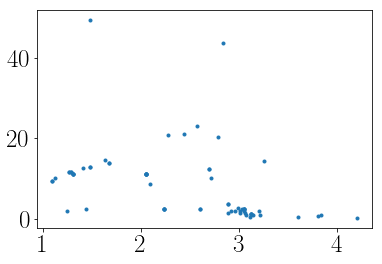

In [307]:
m = 0 < df3.prot.values 
plt.plot(df3.bp[m] - df3.rp[m], df3.prot.values[m], ".")